In [25]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import sklearn.model_selection
from torchvision import transforms
from PIL import Image
import time
import csv
import random
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import torchvision
from sklearn.metrics import roc_auc_score
from torch.utils.data import random_split
from sklearn.metrics import roc_curve, auc

The whole goal of this module is to be able to predict whether a patient has pneumonia from Chest X-ray images and remove confounding factors such as the view the X-ray was taken

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(SEED)

In [3]:
# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chexpert


In [6]:
file_path="/kaggle/input/chexpert"

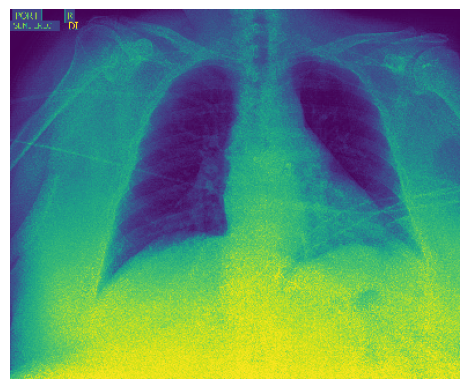

In [7]:
image_path = '/kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg'
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

The CheXpert dataset is a large, publicly available collection of chest radiographs designed for developing and benchmarking machine learning models in medical imaging. Released by researchers at Stanford University in 2019, CheXpert contains 224,316 chest X-rays from 65,240 patients, annotated for the presence of 14 common chest conditions, such as pneumonia, pleural effusion, cardiomegaly, and lung opacity. Also, there is a csv file from training and testing.

Each row in the csv file is about one chest image. It has the file path of where the image is saved, the gender of the patient, age, whether the image is frontal or lateral(side), and whether the image is AP/PA (the direction the image was shot at, from front-to-back or back-to front). There are also labels for 14 diseases including pneumonia. The labels are 1 (disease is present), 0 (disease is not present), or -1 (image is unsure)


In [8]:
pathFileTrain = '/kaggle/input/chexpert/train.csv'
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform=None, policy="ones"):
        self.image_names = []
        self.labels = []
        self.views = []
        self.genders = []
        self.transform = transform

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)  # skip the header
            for line in csvReader:
                if line[3] != 'Lateral':
                    continue

                image_name = line[0].replace("CheXpert-v1.0-small", file_path)
                label = line[5:]

                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            label[i] = 1 if policy == "ones" else 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0

                # Extract gender with default fallback
                sex = line[1]
                if sex == "Male":
                    gender = 1.0
                else:
                    gender = 0.0  # default to 0.0 (for Female, Unknown, or missing)

                self.image_names.append(image_name)
                self.labels.append(label)
                self.views.append(1.0 if "AP" in image_name else 0.0)
                self.genders.append(gender)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        view = self.views[index]
        gender = self.genders[index]
        return image, torch.FloatTensor(label), torch.tensor([view]), torch.tensor([gender])

    def __len__(self):
        return len(self.image_names)

In [9]:
datasetMaster = CheXpertDataSet(pathFileTrain, transform=_transforms['train'], policy = "ones")

In [10]:
split_idx = len(datasetMaster) // 2
datasetTrain = torch.utils.data.Subset(datasetMaster, range(0, split_idx))
datasetValid = torch.utils.data.Subset(datasetMaster, range(split_idx, len(datasetMaster)))

In [11]:
train_loader = DataLoader(datasetTrain, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, generator=g)
valid_loader = DataLoader(datasetValid, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, generator=g)

CXR Classifier is a convolutional neural network where the input is the Chest X-ray images and the output is the 14 different disease classifications.

In [12]:
class CXRClassifier(nn.Module):
    def __init__(self, num_labels=14):
        super(CXRClassifier, self).__init__()
        self.backbone = models.densenet121(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_labels),
            nn.Sigmoid()  # multi-label output
        )

    def forward(self, x):
        return self.backbone(x)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
model = CXRClassifier(num_labels=14).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for i, (images, labels, _, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 254/254 [01:29<00:00,  2.84it/s]


Epoch 1 | Train Loss: 0.4117


100%|██████████| 254/254 [00:28<00:00,  8.77it/s]


Epoch 2 | Train Loss: 0.3740


100%|██████████| 254/254 [00:27<00:00,  9.11it/s]


Epoch 3 | Train Loss: 0.3647


100%|██████████| 254/254 [00:28<00:00,  9.02it/s]


Epoch 4 | Train Loss: 0.3546


100%|██████████| 254/254 [00:28<00:00,  8.81it/s]


Epoch 5 | Train Loss: 0.3440


100%|██████████| 254/254 [00:28<00:00,  9.01it/s]


Epoch 6 | Train Loss: 0.3333


100%|██████████| 254/254 [00:28<00:00,  9.05it/s]


Epoch 7 | Train Loss: 0.3242


100%|██████████| 254/254 [00:28<00:00,  8.93it/s]


Epoch 8 | Train Loss: 0.3138


100%|██████████| 254/254 [00:28<00:00,  9.04it/s]


Epoch 9 | Train Loss: 0.3026


100%|██████████| 254/254 [00:28<00:00,  9.04it/s]

Epoch 10 | Train Loss: 0.2926


In [15]:
all_train_preds_vanilla = []
all_train_labels_vanilla = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for images, labels, _, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size
        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_train_preds_vanilla.append(pneumonia_predict)
        all_train_labels_vanilla.append(pneumonia_actual)

    # Stack all at once
    all_train_preds_vanilla = torch.cat(all_train_preds_vanilla)
    all_train_labels_vanilla= torch.cat(all_train_labels_vanilla)
    # Diagnostic: check for invalid labels once
    auc = roc_auc_score(all_train_labels_vanilla.cpu().numpy(), all_train_preds_vanilla.cpu().numpy())
    print(auc)

0.7364192601850122


In [17]:
all_test_preds_vanilla = []
all_test_labels_vanilla = []
model.eval()
with torch.no_grad():
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels, _, _ in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size

        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_test_preds_vanilla.append(pneumonia_predict)
        all_test_labels_vanilla.append(pneumonia_actual)

    # Stack all at once
    all_test_preds_vanilla = torch.cat(all_test_preds_vanilla)
    all_test_labels_vanilla = torch.cat(all_test_labels_vanilla)
    auc = roc_auc_score(all_test_labels_vanilla.cpu().numpy(), all_test_preds_vanilla.cpu().numpy())
    print(auc)


0.628389199727003


This is the adversarial training. In this case, the main model predicts pneumonia from X-ray. The adversary tries to guess the view's position from the pneumonia prediction. The main model is then trained to make it impossible for the adversary to succeed

In [20]:
class Adversary(nn.Module):
    def __init__(self, n_sensitive, n_hidden=32):
        super(Adversary, self).__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_sensitive),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [21]:
def pretrain_classifier(model, train_loader, optimizer, loss_fn, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels, _, _ in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"[CLF Pretrain] Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

def pretrain_adversary(model, adv, train_loader, optimizer, criterion, pneumo_index):
    adv.train()
    model.eval()
    for epoch in range(1):
        total_loss = 0
        all_preds, all_targets = [], []
        for images, _, views, _ in tqdm(train_loader):
            images = images.to(device)
            views = views.to(device).float()

            with torch.no_grad():
                pneumo_scores = model(images)[:, pneumo_index].unsqueeze(1)

            pred_views = adv(pneumo_scores)
            loss = criterion(pred_views, views).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(pred_views.detach().cpu().numpy())
            all_targets.extend(views.cpu().numpy())

        auroc = roc_auc_score(all_targets, all_preds)
        print(f"[ADV Pretrain] Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f} | AUROC: {auroc:.4f}")

def joint_adversarial_train(model, adv, train_loader, clf_criterion, adv_criterion,
                            clf_optimizer, adv_optimizer, pneumo_index, lam, epochs):
    for epoch in range(epochs):
        model.train()
        adv.train()
        total_clf_loss = 0
        total_adv_loss = 0
        all_preds, all_targets = [], []

        for images, labels, views, _ in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()
            views = views.to(device).float()

            # --- Train Adversary ---
            with torch.no_grad():
                pneumo_scores = model(images)[:, pneumo_index].unsqueeze(1)
            pred_views = adv(pneumo_scores)
            adv_loss = adv_criterion(pred_views, views).mean()

            adv_optimizer.zero_grad()
            adv_loss.backward()
            adv_optimizer.step()

            # --- Train Classifier (with adversarial penalty) ---
            outputs = model(images)
            pneumo_scores = outputs[:, pneumo_index].unsqueeze(1)
            pred_views = adv(pneumo_scores)

            clf_loss = clf_criterion(outputs, labels) - lam * adv_criterion(pred_views, views).mean()

            clf_optimizer.zero_grad()
            clf_loss.backward()
            clf_optimizer.step()

            total_clf_loss += clf_loss.item()
            total_adv_loss += adv_loss.item()
            all_preds.extend(pred_views.detach().cpu().numpy())
            all_targets.extend(views.cpu().numpy())

        adv_auroc = roc_auc_score(all_targets, all_preds)
        print(f"[ADV Training] Epoch {epoch+1} | Clf Loss: {total_clf_loss/len(train_loader):.4f} | "
              f"Adv Loss: {total_adv_loss/len(train_loader):.4f}")

# === Setup ===
SEED = 42
torch.manual_seed(SEED)
model_adv = CXRClassifier(num_labels=14).to(device)
adv = Adversary(n_sensitive=1).to(device)

clf_optimizer = optim.Adam(model_adv.parameters(), lr=1e-4)
adv_optimizer = optim.Adam(adv.parameters(), lr=1e-4)

loss_fn = nn.BCELoss()
adv_loss_fn = nn.BCELoss(reduction='none')
pneumonia_index = class_names.index("Pneumonia")
lam = 0.1 # lowered to avoid overpowering classifier

# === Run Training ===

print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))
print("Train samples:", len(train_loader.dataset))
print("Valid samples:", len(valid_loader.dataset))

pretrain_classifier(model_adv, train_loader, clf_optimizer, loss_fn, epochs=1)
pretrain_adversary(model_adv, adv, train_loader, adv_optimizer, adv_loss_fn, pneumonia_index)
joint_adversarial_train(model_adv, adv, train_loader, loss_fn, adv_loss_fn,
                        clf_optimizer, adv_optimizer, pneumonia_index, lam, epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train batches: 254
Valid batches: 254
Train samples: 16193
Valid samples: 16194


100%|██████████| 254/254 [00:28<00:00,  8.81it/s]


[CLF Pretrain] Epoch 1 | Loss: 0.4117


100%|██████████| 254/254 [00:18<00:00, 13.45it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Pretrain] Epoch 1 | Loss: 0.6576 | AUROC: nan


100%|██████████| 254/254 [00:36<00:00,  6.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 1 | Clf Loss: 0.3339 | Adv Loss: 0.4018


100%|██████████| 254/254 [00:36<00:00,  6.97it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 2 | Clf Loss: 0.3513 | Adv Loss: 0.1338


100%|██████████| 254/254 [00:35<00:00,  7.07it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 3 | Clf Loss: 0.3508 | Adv Loss: 0.0379


100%|██████████| 254/254 [00:36<00:00,  7.00it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 4 | Clf Loss: 0.3425 | Adv Loss: 0.0146


100%|██████████| 254/254 [00:35<00:00,  7.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 5 | Clf Loss: 0.3328 | Adv Loss: 0.0073


100%|██████████| 254/254 [00:36<00:00,  7.03it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 6 | Clf Loss: 0.3253 | Adv Loss: 0.0042


100%|██████████| 254/254 [00:35<00:00,  7.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 7 | Clf Loss: 0.3141 | Adv Loss: 0.0027


100%|██████████| 254/254 [00:36<00:00,  6.92it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 8 | Clf Loss: 0.3051 | Adv Loss: 0.0016


100%|██████████| 254/254 [00:36<00:00,  7.01it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV Training] Epoch 9 | Clf Loss: 0.2940 | Adv Loss: 0.0009


100%|██████████| 254/254 [00:36<00:00,  7.01it/s]

[ADV Training] Epoch 10 | Clf Loss: 0.2781 | Adv Loss: 0.0005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [22]:
all_train_preds_adv = []
all_train_labels_adv = []

model_adv.eval()
with torch.no_grad():
    total_loss = 0
    for images, labels, _, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adv(images)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size
        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_train_preds_adv.append(pneumonia_predict)
        all_train_labels_adv.append(pneumonia_actual)

    # Stack all at once
    all_train_preds_adv = torch.cat(all_train_preds_adv)
    all_train_labels_adv = torch.cat(all_train_labels_adv)

In [23]:
all_test_preds_adv = []
all_test_labels_adv = []

model_adv.eval()
with torch.no_grad():
    total_loss = 0
    for images, labels, _, _ in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adv(images)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size
        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_test_preds_adv.append(pneumonia_predict)
        all_test_labels_adv.append(pneumonia_actual)

    # Stack all at once
    all_test_preds_adv = torch.cat(all_test_preds_adv)
    all_test_labels_adv = torch.cat(all_test_labels_adv)


The below chart shows the ROC-AUC curve for the pneumonia classifier that was trained alone without any adversary.

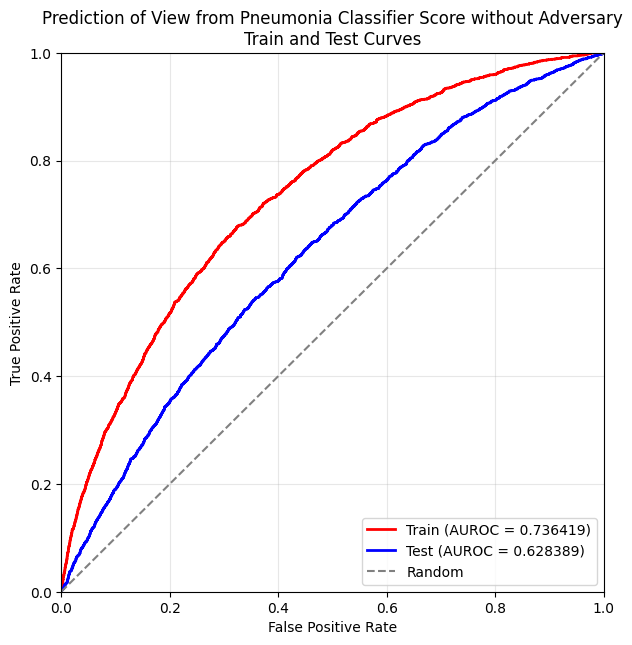

In [26]:
train_preds = all_train_preds_vanilla.detach().cpu().numpy()
train_labels = all_train_labels_vanilla.detach().cpu().numpy()

test_preds = all_test_preds_vanilla.detach().cpu().numpy()
test_labels = all_test_labels_vanilla.detach().cpu().numpy()

# Calculate ROC curves and AUROCs
fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(test_labels, test_preds)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'Train (AUROC = {roc_auc_train:.6f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test (AUROC = {roc_auc_test:.6f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction of View from Pneumonia Classifier Score without Adversary\nTrain and Test Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



The below chart shows the ROC-AUC curve for the pneumonia classifier that was trained with the view as an adversary




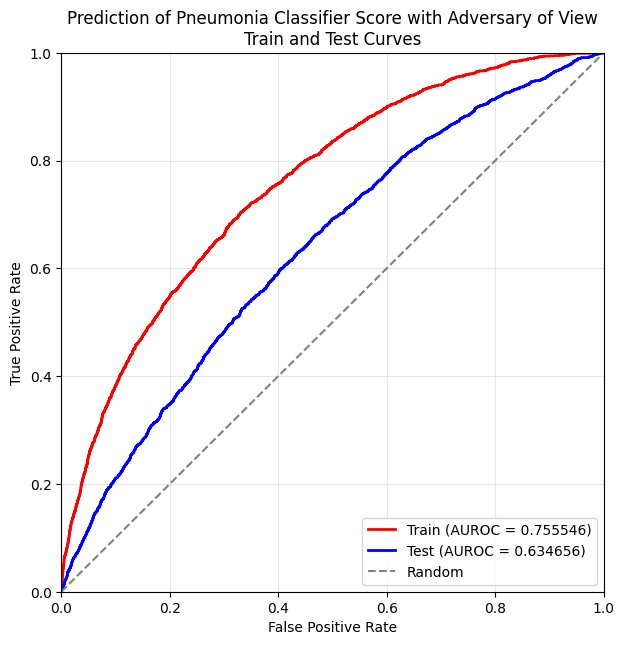

In [33]:
train_preds = all_train_preds_adv.detach().cpu().numpy()
train_labels = all_train_labels_adv.detach().cpu().numpy()

test_preds = all_test_preds_adv.detach().cpu().numpy()
test_labels = all_test_labels_adv.detach().cpu().numpy()

# Calculate ROC curves and AUROCs
fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(test_labels, test_preds)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'Train (AUROC = {roc_auc_train:.6f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test (AUROC = {roc_auc_test:.6f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction of Pneumonia Classifier Score with Adversary of View\nTrain and Test Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Adversarial training was done, but now with both view and gender as the adversary.

In [28]:
def pretrain_classifier(model, train_loader, optimizer, loss_fn, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels, _, _ in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[CLF Pretrain] Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

def pretrain_adversary(model, adv, train_loader, optimizer, criterion, pneumo_index, target='view'):
    adv.train()
    model.eval()
    for epoch in range(1):
        total_loss = 0
        all_preds, all_targets = [], []
        for images, _, views, genders in tqdm(train_loader):
            images = images.to(device)
            target_vals = views if target == 'view' else genders
            target_vals = target_vals.to(device).float()

            with torch.no_grad():
                pneumo_scores = model(images)[:, pneumo_index].unsqueeze(1)

            pred = adv(pneumo_scores)
            loss = criterion(pred, target_vals).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.extend(pred.detach().cpu().numpy())
            all_targets.extend(target_vals.cpu().numpy())

        auroc = roc_auc_score(all_targets, all_preds)
        print(f"[ADV {target.upper()} Pretrain] Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f} | AUROC: {auroc:.4f}")

# === Joint Adversarial Training ===

def joint_adversarial_train(model, adv_view, adv_gender, train_loader,
                            clf_criterion, adv_criterion,
                            clf_optimizer, adv_view_optimizer, adv_gender_optimizer,
                            pneumo_index, lam_view, lam_gender, epochs):
    for epoch in range(epochs):
        model.train()
        adv_view.train()
        adv_gender.train()

        total_clf_loss = 0
        total_adv_view_loss = 0
        total_adv_gender_loss = 0
        all_preds_view, all_targets_view = [], []
        all_preds_gender, all_targets_gender = [], []

        for images, labels, views, genders in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()
            views = views.to(device).float()
            genders = genders.to(device).float()

            # Train View Adversary
            with torch.no_grad():
                pneumo_scores = model(images)[:, pneumo_index].unsqueeze(1)
            pred_views = adv_view(pneumo_scores)
            adv_view_loss = adv_criterion(pred_views, views).mean()

            adv_view_optimizer.zero_grad()
            adv_view_loss.backward()
            adv_view_optimizer.step()

            # Train Gender Adversary
            with torch.no_grad():
                pneumo_scores = model(images)[:, pneumo_index].unsqueeze(1)
            pred_genders = adv_gender(pneumo_scores)
            adv_gender_loss = adv_criterion(pred_genders, genders).mean()

            adv_gender_optimizer.zero_grad()
            adv_gender_loss.backward()
            adv_gender_optimizer.step()

            # Train Classifier (with adversarial penalty)
            outputs = model(images)
            pneumo_scores = outputs[:, pneumo_index].unsqueeze(1)
            pred_views = adv_view(pneumo_scores)
            pred_genders = adv_gender(pneumo_scores)

            clf_loss = (
                clf_criterion(outputs, labels)
                - lam_view * adv_criterion(pred_views, views).mean()
                - lam_gender * adv_criterion(pred_genders, genders).mean()
            )

            clf_optimizer.zero_grad()
            clf_loss.backward()
            clf_optimizer.step()

            total_clf_loss += clf_loss.item()
            total_adv_view_loss += adv_view_loss.item()
            total_adv_gender_loss += adv_gender_loss.item()
            all_preds_view.extend(pred_views.detach().cpu().numpy())
            all_targets_view.extend(views.cpu().numpy())
            all_preds_gender.extend(pred_genders.detach().cpu().numpy())
            all_targets_gender.extend(genders.cpu().numpy())

        auroc_view = roc_auc_score(all_targets_view, all_preds_view)
        auroc_gender = roc_auc_score(all_targets_gender, all_preds_gender)
        print(f"[JOINT TRAIN] Epoch {epoch+1} | Clf Loss: {total_clf_loss/len(train_loader):.4f} | "
              f"View Adv Loss: {total_adv_view_loss/len(train_loader):.4f} | "
              f"Gender Adv Loss: {total_adv_gender_loss/len(train_loader):.4f} | "
              f"View AUROC: {auroc_view:.4f} | Gender AUROC: {auroc_gender:.4f}")

# === Setup and Run ===

SEED = 42
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
model_adv_with_gender = CXRClassifier(num_labels=14).to(device)
adv_view = Adversary(n_sensitive=1).to(device)
adv_gender = Adversary(n_sensitive=1).to(device)

# Optimizers
clf_optimizer = optim.Adam(model_adv_with_gender.parameters(), lr=1e-4)
adv_view_optimizer = optim.Adam(adv_view.parameters(), lr=1e-4)
adv_gender_optimizer = optim.Adam(adv_gender.parameters(), lr=1e-4)

# Losses
loss_fn = nn.BCELoss()
adv_loss_fn = nn.BCELoss(reduction='none')

# Hyperparameters
pneumonia_index = class_names.index("Pneumonia")
lam_view = 0.1
lam_gender = 0.1

# Print basic stats
print("Train batches:", len(train_loader))
print("Valid batches:", len(valid_loader))
print("Train samples:", len(train_loader.dataset))
print("Valid samples:", len(valid_loader.dataset))

# Run training
pretrain_classifier(model_adv_with_gender, train_loader, clf_optimizer, loss_fn, epochs=1)
pretrain_adversary(model_adv_with_gender, adv_view, train_loader, adv_view_optimizer, adv_loss_fn, pneumonia_index, target='view')
pretrain_adversary(model_adv_with_gender, adv_gender, train_loader, adv_gender_optimizer, adv_loss_fn, pneumonia_index, target='gender')

joint_adversarial_train(model_adv_with_gender, adv_view, adv_gender, train_loader,
                        loss_fn, adv_loss_fn,
                        clf_optimizer, adv_view_optimizer, adv_gender_optimizer,
                        pneumonia_index, lam_view, lam_gender, epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train batches: 254
Valid batches: 254
Train samples: 16193
Valid samples: 16194


100%|██████████| 254/254 [00:28<00:00,  8.83it/s]


[CLF Pretrain] Epoch 1 | Loss: 0.4117


100%|██████████| 254/254 [00:19<00:00, 12.83it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[ADV VIEW Pretrain] Epoch 1 | Loss: 0.6576 | AUROC: nan


100%|██████████| 254/254 [00:19<00:00, 13.14it/s]


[ADV GENDER Pretrain] Epoch 1 | Loss: 0.6656 | AUROC: 0.5067


100%|██████████| 254/254 [00:44<00:00,  5.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 1 | Clf Loss: 0.2683 | View Adv Loss: 0.4017 | Gender Adv Loss: 0.6562 | View AUROC: nan | Gender AUROC: 0.5066


100%|██████████| 254/254 [00:43<00:00,  5.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 2 | Clf Loss: 0.2860 | View Adv Loss: 0.1338 | Gender Adv Loss: 0.6536 | View AUROC: nan | Gender AUROC: 0.5018


100%|██████████| 254/254 [00:44<00:00,  5.77it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 3 | Clf Loss: 0.2858 | View Adv Loss: 0.0380 | Gender Adv Loss: 0.6532 | View AUROC: nan | Gender AUROC: 0.4962


100%|██████████| 254/254 [00:43<00:00,  5.79it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 4 | Clf Loss: 0.2775 | View Adv Loss: 0.0146 | Gender Adv Loss: 0.6532 | View AUROC: nan | Gender AUROC: 0.4957


100%|██████████| 254/254 [00:44<00:00,  5.77it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 5 | Clf Loss: 0.2684 | View Adv Loss: 0.0073 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.4968


100%|██████████| 254/254 [00:44<00:00,  5.74it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 6 | Clf Loss: 0.2590 | View Adv Loss: 0.0042 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.5006


100%|██████████| 254/254 [00:44<00:00,  5.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 7 | Clf Loss: 0.2511 | View Adv Loss: 0.0027 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.5005


100%|██████████| 254/254 [00:43<00:00,  5.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 8 | Clf Loss: 0.2414 | View Adv Loss: 0.0017 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.5005


100%|██████████| 254/254 [00:44<00:00,  5.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 9 | Clf Loss: 0.2278 | View Adv Loss: 0.0010 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.5007


100%|██████████| 254/254 [00:43<00:00,  5.80it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[JOINT TRAIN] Epoch 10 | Clf Loss: 0.2186 | View Adv Loss: 0.0006 | Gender Adv Loss: 0.6531 | View AUROC: nan | Gender AUROC: 0.5003


In [30]:
all_train_preds_adv_second = []
all_train_labels_adv_second = []

model_adv.eval()
with torch.no_grad():
    total_loss = 0
    for images, labels, _, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adv_with_gender(images)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size
        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_train_preds_adv_second.append(pneumonia_predict)
        all_train_labels_adv_second.append(pneumonia_actual)

    # Stack all at once
    all_train_preds_adv_second = torch.cat(all_train_preds_adv_second)
    all_train_labels_adv_second = torch.cat(all_train_labels_adv_second)

In [31]:
all_test_preds_adv_second = []
all_test_labels_adv_second = []

model_adv.eval()
with torch.no_grad():
    total_loss = 0
    for images, labels, _, _ in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adv_with_gender(images)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)  # accumulate weighted by batch size
        pneumonia_predict = outputs[:, 7]
        pneumonia_actual = labels[:, 7]
        all_test_preds_adv_second.append(pneumonia_predict)
        all_test_labels_adv_second.append(pneumonia_actual)

    # Stack all at once
    all_test_preds_adv_second= torch.cat(all_test_preds_adv_second)
    all_test_labels_adv_second = torch.cat(all_test_labels_adv_second)

The below chart shows the ROC-AUC curve for the pneumonia classifier that was trained with the view as well as the gender as an adversary

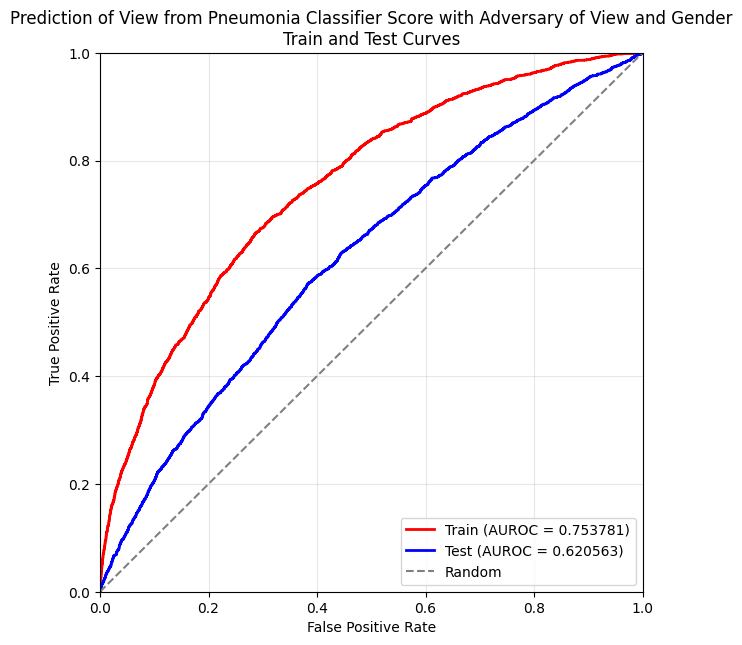

In [32]:
train_preds = all_train_preds_adv_second.detach().cpu().numpy()
train_labels = all_train_labels_adv_second.detach().cpu().numpy()

test_preds = all_test_preds_adv_second.detach().cpu().numpy()
test_labels = all_test_labels_adv_second.detach().cpu().numpy()

# Calculate ROC curves and AUROCs
fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(test_labels, test_preds)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'Train (AUROC = {roc_auc_train:.6f})')
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test (AUROC = {roc_auc_test:.6f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Prediction of View from Pneumonia Classifier Score with Adversary of View and Gender\nTrain and Test Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
